In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.graph_objects as go
import math
import statistics
import datatable as dt 
import random
import warnings
import cv2
from scipy import ndimage
import skimage.io
import time
from PIL import Image
from io import BytesIO
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances
pd.__version__

'1.4.2'

In [18]:
import os
os.getcwd()
warnings.filterwarnings('ignore')

In [19]:
#User inputs
#enter image size in terms of pixels
x_dim=512
y_dim=512
z_dim=512
#enter pixel range for cropping. For ManC: 250-750
x_min=0
x_max=500
y_min=0
y_max=500
z_min=0
z_max=500
#enter size of the coarsened image in pixels
x_pixels=250
y_pixels=250
z_pixels=250
#check solid and pore value. ManU image: pore value=1 and solid value=0
solid_value=0
pore_value=255
micro_pore_value=[]

#input porosities of micropores
micro_pore_poro=[]
micro_pore_perm=[]    #mD

#enter pressure differential direction
flow_direction= 2 #1=x axis, 2=y-axis, 3=z-axis

#enter the threshold factor above which a given coarse pixel is solid
buffer=0.8

#internal calculation
img_size= (x_max-x_min)*(y_max-y_min)*(z_max-z_min)
solid_pixels_max=(int)((x_max-x_min)/x_pixels)*((y_max-y_min)/y_pixels)*((z_max-z_min)/z_pixels)

In [20]:
#Data import and conversion

img = np.fromfile('Ketton.raw', dtype='uint8', sep="")  
img = np.reshape(img, (z_dim, y_dim, x_dim))
img_crop = img[z_min:z_max,y_min:y_max,x_min:x_max]

In [21]:
%%time
#image coarsening

img_coarse=np.zeros((z_pixels,y_pixels,x_pixels), dtype='int32')
pore_character=[[[]]]

k=0
for k in range (z_pixels):
    j=0
    for j in range (y_pixels):
        i=0
        for i in range (x_pixels):
            x1_min=i*(int)((x_max-x_min)/x_pixels)
            x1_max=(i+1)*(int)((x_max-x_min)/x_pixels)
            y1_min=j*(int)((y_max-y_min)/y_pixels)
            y1_max=(j+1)*(int)((y_max-y_min)/y_pixels)
            z1_min=k*(int)((z_max-z_min)/z_pixels)
            z1_max=(k+1)*(int)((z_max-z_min)/z_pixels)
            
            img_crp=img_crop[z1_min:z1_max,y1_min:y1_max,x1_min:x1_max]
            
            #computing the number of solid pixels from the original image in one big cell of the coarsened image
            solid_size=np.count_nonzero(img_crp == solid_value)
            img_coarse[k][j][i]=solid_size
            
            if((len(micro_pore_value)>0) and solid_size<buffer*solid_pixels_max):
                local_character=[]
                local_character.append(i)
                local_character.append(j)
                local_character.append(k)
                pore_size=np.count_nonzero(img_crp == pore_value)
                local_character.append(pore_size)
                big_phase=pore_value
                big_phase_size=pore_size
                l=0
                for l in range(len(micro_pore_value)):
                    micro_pore_size=np.count_nonzero(img_crp == micro_pore_value[l])
                    local_character.append(micro_pore_size)
                    if(micro_pore_size>big_phase_size):
                        big_phase=micro_pore_value[l]
                        big_phase_size=micro_pore_size
                local_character.append(big_phase)
                pore_character.append(local_character)

if((len(micro_pore_value)>0)):                
    pore_character.pop(0)
    df_pore_character=pd.DataFrame(columns=['dummy'])
    df_pore_character['dummy']=pore_character
    df_pore_character=pd.DataFrame(df_pore_character['dummy'].to_list())
              

CPU times: total: 1min 48s
Wall time: 1min 48s


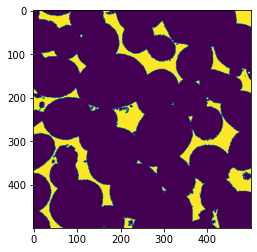

In [22]:
#vizualizing original image in 2D
imgxx1=img_crop[0]
imgplot = plt.imshow(imgxx1)

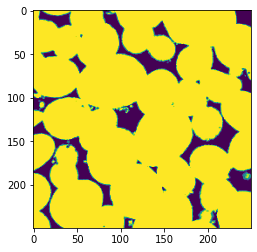

In [23]:
#vizualizing coarsened image in 2D
imgxx2=img_coarse[0]
imgplot = plt.imshow(imgxx2)

CPU times: total: 49.2 s
Wall time: 49.4 s


<function matplotlib.pyplot.show(close=None, block=None)>

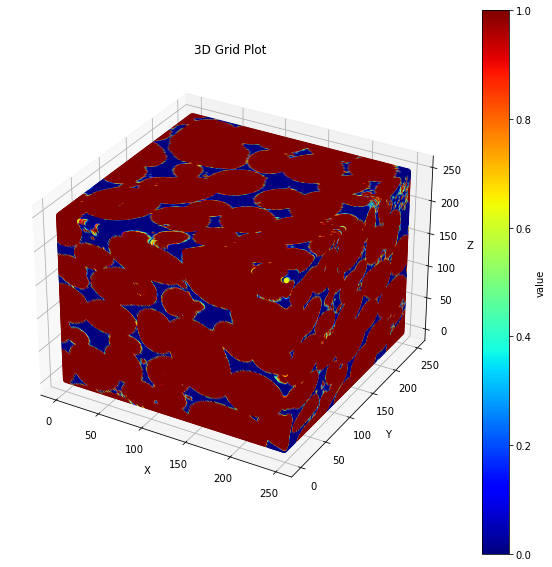

In [24]:
%%time
#vizualizing coarsened image in 3D

xx2=[]   #to store x coordinate
yy2=[]   #to store y coordinate
zz2=[]   #to store z coordinate
val2=[]   #to store pixel value at a given coordinate

k=0
count=0
for k in range(z_pixels):
    j=0
    for j in range(y_pixels):
        i=0
        for i in range(x_pixels):
            xx2.append(i)
            yy2.append(j)
            zz2.append(k)
            vv2=img_coarse[k][j][i]/solid_pixels_max
            val2.append(vv2)
           
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')

ax.scatter(xx2,yy2,zz2,c=val2,cmap=cm.jet)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Grid Plot')

cbar=fig.colorbar(ax.collections[0], ax=ax, label='value')

plt.show

In [25]:
%%time
#separating the coordinates of solid and pore voxels and size of solid grains in separate lists
solid_coor=[]
pore_coor=[]
pore_size=[]
solid_boundary_coor=[]

k=0
for k in range(z_pixels):
    j=0
    for j in range(y_pixels):
        i=0
        for i in range(x_pixels):
            if(img_coarse[k][j][i]>=(buffer*solid_pixels_max)):
                coor_s=[i,j,k]
                solid_coor.append(coor_s)
                if((i<(x_pixels-1)) and (j<(y_pixels-1)) and (k<(z_pixels-1))):
                    if((img_coarse[k][j][i+1]<(buffer*solid_pixels_max)) or (img_coarse[k][j][i-1]<(buffer*solid_pixels_max)) or (img_coarse[k][j+1][i]<(buffer*solid_pixels_max)) or (img_coarse[k][j-1][i]<(buffer*solid_pixels_max)) or (img_coarse[k+1][j][i]<(buffer*solid_pixels_max)) or (img_coarse[k-1][j][i]<(buffer*solid_pixels_max))):
                        solid_boundary_coor.append(coor_s)
            
            else:
                if(len(micro_pore_value)==0):
                    coor_p=[i,j,k]
                    size_p=solid_pixels_max-img_coarse[k][j][i]
                    pore_coor.append(coor_p)
                    pore_size.append(size_p)
                else:
                    target_index=np.where((df_pore_character[0]==i) & (df_pore_character[1]==j) & (df_pore_character[2]==k))[0]
                    ncol11=df_pore_character.shape[1]
                    phase=df_pore_character.iat[target_index[0],(ncol11-1)]
                    coor_p=[i,j,k,phase]
                    if(phase==pore_value):
                        size_p=df_pore_character.iat[target_index[0],3]
                    else:
                        size_p=0.00001
                    pore_coor.append(coor_p)
                    pore_size.append(size_p)
                        


CPU times: total: 3min 20s
Wall time: 3min 25s


In [26]:
len(pore_coor)

2360575

In [ ]:
%%time

#computing the distance of each pore to nearest solid
if(len(solid_boundary_coor)==0):
    coor_ss=[(1000*x_pixels),(1000*y_pixels),(1000*y_pixels)]
    solid_boundary_coor.append(coor_ss)
    
df_dist=pd.DataFrame(columns=['solid_x','solid_y','solid_z','current_pore_x','current_pore_y','current_pore_z','distance'])
df_tmp=pd.DataFrame(columns=['dummy'])
df_tmp['dummy']=solid_boundary_coor
df_tmp=pd.DataFrame(df_tmp['dummy'].to_list())
df_dist['solid_x']=df_tmp[0]
df_dist['solid_y']=df_tmp[1]
df_dist['solid_z']=df_tmp[2]
    
min_dist=[None]*len(pore_coor)
i=0
for i in range(len(pore_coor)):
    x1=pore_coor[i][0]
    y1=pore_coor[i][1]
    z1=pore_coor[i][2]

    df_dist['current_pore_x']=x1
    df_dist['current_pore_y']=y1
    df_dist['current_pore_z']=z1

    df_dist['distance']=((((df_dist['current_pore_x']-df_dist['solid_x'])**2)+((df_dist['current_pore_y']-df_dist['solid_y'])**2)+((df_dist['current_pore_z']-df_dist['solid_z'])**2))**0.5)
    if(len(micro_pore_value)==0):
        min_dist[i]=min(df_dist['distance'])

    else:
        pore_ctr=pore_coor[i][3]
        if(pore_ctr==pore_value):
            min_dist[i]=min(df_dist['distance'])
        else:
            min_dist[i]=0.00001
        

In [ ]:
%%time
#identifying the voxels on the injection and the exit boundaries
injection_cells=[]
exit_cells=[]

df_dist2=pd.DataFrame(columns=['pore_x','pore_y','pore_z'])
df_tmp2=pd.DataFrame(columns=['dummy'])
df_tmp2['dummy']=pore_coor
df_tmp2=pd.DataFrame(df_tmp2['dummy'].to_list())
df_dist2['pore_x']=df_tmp2[0]
df_dist2['pore_y']=df_tmp2[1]
df_dist2['pore_z']=df_tmp2[2]
    

if (flow_direction==1):
    injection_cells=np.where(df_dist2["pore_x"]==0)[0]
    exit_cells=np.where(df_dist2["pore_x"]==((x_pixels)-1))[0]

if (flow_direction==2):
    injection_cells=np.where(df_dist2["pore_y"]==0)[0]
    exit_cells=np.where(df_dist2["pore_y"]==((y_pixels)-1))[0]
                        
if (flow_direction==3):
    injection_cells=np.where(df_dist2["pore_z"]==0)[0]
    exit_cells=np.where(df_dist2["pore_z"]==((z_pixels)-1))[0]


In [ ]:
%%time

#construct graph
g=nx.Graph()

#add nodes
i=0
for i in range (len(pore_coor)):
    g.add_node(i,pos=(pore_coor[i][0],pore_coor[i][1],pore_coor[i][2]))
pseudo_inj_ind=len(pore_coor)
pseudo_exit_ind=len(pore_coor)+1

if(flow_direction==1):
    g.add_node(pseudo_inj_ind,pos=(0.5,0,0))
    g.add_node(pseudo_exit_ind,pos=((x_pixels+0.5),0,0))
if(flow_direction==2):
    g.add_node(pseudo_inj_ind,pos=(0,0.5,0))
    g.add_node(pseudo_exit_ind,pos=(0,(y_pixels+0.5),0))
if(flow_direction==3):
    g.add_node(pseudo_inj_ind,pos=(0,0,0.5))
    g.add_node(pseudo_exit_ind,pos=(0,0,(x_pixels+0.5)))

        
#add edges
k=0
for k in range(z_pixels-1):
    j=0
    for j in range(y_pixels-1):
        i=0
        for i in range(x_pixels-1):
            
            if(img_coarse[k][j][i]<(buffer*solid_pixels_max)):
                current_index=np.where((df_dist2["pore_x"]==i) & (df_dist2["pore_y"]==j) & (df_dist2["pore_z"]==k))[0]
            
                if((df_dist2.iat[(i+1),0]%x_pixels>0)):     #and ((df_dist2.iat[(i+1),0]-df_dist2.iat[(i),0])==1)):
                    if((img_coarse[k][j][i+1]<(buffer*solid_pixels_max))):
                        x_neigh=np.where((df_dist2["pore_x"]==(i+1)) & (df_dist2["pore_y"]==j) & (df_dist2["pore_z"]==k))[0]

                        
                        min_distance2=min_dist[x_neigh[0]]
                        pore_size_resistance=pore_size[x_neigh[0]]/solid_pixels_max   #resistance due to the pore size. Higher value implies a smaller pore
                        if(flow_direction==1):                        
                            pressure_diff_resistance=0.5
                        if(flow_direction==2):                        
                            pressure_diff_resistance=2
                        if(flow_direction==3):                        
                            pressure_diff_resistance=2
#                         r=((pressure_diff_resistance*pore_size_resistance)/(0.000001+min_dist))
                        
                        if(len(micro_pore_value)==0):
                            r=((pressure_diff_resistance)/(pore_size_resistance*(0.000001+min_distance2)))      #net resistance of the path  
        
                        if(len(micro_pore_value)>0):
                            if(pore_coor[x_neigh[0]][3]==pore_value):
                                r=((pressure_diff_resistance)/(pore_size_resistance*(0.000001+min_distance2)))
                            else:
                                phase1=pore_coor[x_neigh[0]][3]
                                phase1_index=micro_pore_value.index(phase1)
                                r=((pressure_diff_resistance)/(micro_pore_poro[phase1_index]*pore_size_resistance*(0.000001+min_distance2)))

    
#                         r=((pressure_diff_resistance)/(0.000001+min_distance2))

                        g.add_edge(current_index[0], x_neigh[0], weight=r)
                    
                
                if(((j+1)%y_pixels>0)): #and ((df_dist2.iat[(j+1),0]-df_dist2.iat[(j),0])==1)):
                    if((img_coarse[k][j+1][i]<(buffer*solid_pixels_max))):
                        y_neigh=np.where((df_dist2["pore_x"]==(i)) & (df_dist2["pore_y"]==(j+1)) & (df_dist2["pore_z"]==k))[0]

                        min_distance2=min_dist[y_neigh[0]]
                        pore_size_resistance=pore_size[y_neigh[0]]/solid_pixels_max   #resistance due to the pore size. Higher value implies a smaller pore
                        if(flow_direction==1):                        
                            pressure_diff_resistance=2
                        if(flow_direction==2):                        
                            pressure_diff_resistance=0.5
                        if(flow_direction==3):                        
                            pressure_diff_resistance=2
#                         r=((pressure_diff_resistance*pore_size_resistance)/(0.000001+min_dist))
                        
                        if(len(micro_pore_value)==0):
                            r=((pressure_diff_resistance)/(pore_size_resistance*(0.000001+min_distance2)))      #net resistance of the path  
        
                        if(len(micro_pore_value)>0):
                            if(pore_coor[y_neigh[0]][3]==pore_value):
                                r=((pressure_diff_resistance)/(pore_size_resistance*(0.000001+min_distance2)))
                            else:
                                phase1=pore_coor[y_neigh[0]][3]
                                phase1_index=micro_pore_value.index(phase1)
                                r=((pressure_diff_resistance)/(micro_pore_poro[phase1_index]*pore_size_resistance*(0.000001+min_distance2)))

   
    
#                         r=((pressure_diff_resistance)/(0.000001+min_distance2))

                        g.add_edge(current_index[0], y_neigh[0], weight=r)
                    
                    
                if(((k+1)%z_pixels>0)): #and ((df_dist2.iat[(k+1),0]-df_dist2.iat[(k),0])==1)):
                    if((img_coarse[k+1][j][i]<(buffer*solid_pixels_max))):
                        z_neigh=np.where((df_dist2["pore_x"]==(i)) & (df_dist2["pore_y"]==(j)) & (df_dist2["pore_z"]==(k+1)))[0]

                        min_distance2=min_dist[z_neigh[0]]
                        pore_size_resistance=pore_size[z_neigh[0]]/solid_pixels_max   #resistance due to the pore size. Higher value implies a smaller pore
                        if(flow_direction==1):                        
                            pressure_diff_resistance=2
                        if(flow_direction==2):                        
                            pressure_diff_resistance=2
                        if(flow_direction==3):                        
                            pressure_diff_resistance=0.5
#                         r=((pressure_diff_resistance*pore_size_resistance)/(0.000001+min_dist))
                    
                        if(len(micro_pore_value)==0):
                            r=((pressure_diff_resistance)/(pore_size_resistance*(0.000001+min_distance2)))      #net resistance of the path  
        
                        if(len(micro_pore_value)>0):
                            if(pore_coor[z_neigh[0]][3]==pore_value):
                                r=((pressure_diff_resistance)/(pore_size_resistance*(0.000001+min_distance2)))
                            else:
                                phase1=pore_coor[z_neigh[0]][3]
                                phase1_index=micro_pore_value.index(phase1)
                                r=((pressure_diff_resistance)/(micro_pore_poro[phase1_index]*pore_size_resistance*(0.000001+min_distance2)))
    
    
    
#                         r=((pressure_diff_resistance)/(0.000001+min_distance2))

                        g.add_edge(current_index[0], z_neigh[0], weight=r)
                
i=0
for i in range(len(injection_cells)):
    r=0.000001
    g.add_edge(pseudo_inj_ind, injection_cells[i], weight=r)
    
    
i=0
for i in range(len(exit_cells)):
    r=0.000001
    g.add_edge(pseudo_exit_ind, exit_cells[i], weight=r)


path=nx.dijkstra_path(g,source=pseudo_inj_ind,target=pseudo_exit_ind,weight='weight')
net_resistance=nx.path_weight(g,path,weight="weight") #m/m
print(net_resistance, len(path))




In [ ]:
%%time
#visualizing path

xx1=[]
yy1=[]
zz1=[]
val1=[]
i=1
for i in range(1,(len(path)-1)):
    xx1.append(pore_coor[path[i]][0])
    yy1.append(pore_coor[path[i]][1])
    zz1.append(pore_coor[path[i]][2])
    val1.append(1)


fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')

ax.scatter(xx1,yy1,zz1,c=val1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Grid Plot')

cbar=fig.colorbar(ax.collections[0], ax=ax, label='probability')

plt.show